# Train

this script is to train the model after the parameters have been optimised.
The final model is output to the output directory in the current directory. This can be changed as described in the [Simple transformers docs](https://simpletransformers.ai/docs/installation/).
THis script also shows how the target classification can be prepared/trained.

### SDG Classifier

In [1]:
import wandb
import torch
import sklearn
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs

In [2]:
# see GPU avaialability
cuda_available = torch.cuda.is_available()

% PER CLASS:

 SDG1      4.686959
SDG2      2.662763
SDG3      6.276512
SDG4      7.476519
SDG5     15.678534
SDG6      1.347068
SDG7      0.315688
SDG8     10.896150
SDG9      0.552291
SDG10    10.155622
SDG11     2.888254
SDG12     0.971902
SDG13     0.998699
SDG14     0.289544
SDG15     0.369937
SDG16    28.666200
SDG17     5.767358
dtype: float64


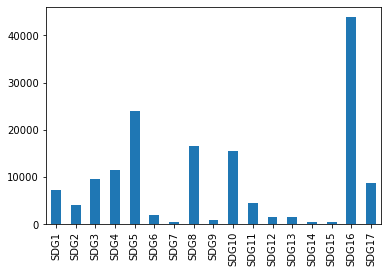

In [34]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')
data = data[data['source']!='SASDG_Hub'] #keep the articles classified by Willem separate as an unseen testing set

# reformat data
sdg_lst = ['SDG1','SDG2','SDG3','SDG4','SDG5','SDG6','SDG7','SDG8','SDG9','SDG10','SDG11','SDG12','SDG13','SDG14','SDG15','SDG16','SDG17']
data['y'] = data[sdg_lst].values.tolist()
y = data['y']
X = data['abstract']

# plot ratio of data
class_weight = (data[sdg_lst].sum()/ data[sdg_lst].sum().sum())
print('% PER CLASS:\n\n', class_weight*100)
data[sdg_lst].sum().plot.bar()

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# add data to dataframes
train_df = pd.DataFrame()
train_df['text'] = X_train
train_df['labels'] = y_train
train_df.reset_index(inplace=True, drop=True)

eval_df = pd.DataFrame()
eval_df['text'] = X_val
eval_df['labels'] = y_val
eval_df.reset_index(inplace=True, drop=True)

# get number of classes
label_count = len(sdg_lst)

In [4]:
# # create functions for additional evaluation outputs
# def acc_result(true, pred):
#     true=np.argmax(true, axis=1)
#     pred=np.argmax(pred, axis=1)
#     acc = sklearn.metrics.accuracy_score(true, pred)
#     return acc

# def f1_macro_result(true, pred):
#     true=np.argmax(true, axis=1)
#     pred=np.argmax(pred, axis=1)
#     f1 = sklearn.metrics.f1_score(true, pred, average='macro')
#     return f1

# def f1_micro_result(true, pred):
#     true=np.argmax(true, axis=1)
#     pred=np.argmax(pred, axis=1)
#     f1 = sklearn.metrics.f1_score(true, pred, average='micro')
#     return f1

# def cm_result(true, pred):
#     true=np.argmax(true, axis=1)
#     pred=np.argmax(pred, axis=1)
#     cm = wandb.plot.confusion_matrix(probs=None, y_true=true, preds=pred, class_names=sdg_lst) #sklearn.metrics.multilabel_confusion_matrix(true, pred)
#     return cm

# # create function for creating layer learning rate dictionary
# # this is used for freezing the number of layers from the first layer -> x layer
# def create_custom_layer_dict_lst(x):    
#     # get list of number of layers
#     # layers_lst = [0]
#     # for i in model.get_named_parameters():
#     #     layers_lst.append(int(re.findall(r"layer\.(\d+)", i)[0]))
#     #     layers_lst = list(set(layers_lst))
#     # create dictionary of 
#     layer_dict_lst = []
#     for i in range(x+1):
#         layer_dict_lst.append({'layer':i, 'lr':0.0})
#     return layer_dict_lst

In [4]:
# # train with optimal parameters from parameter tunign results
# # logging
# logging.basicConfig(level=logging.INFO)
# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

# # Optional model configuration (all parameters defind in sweep config in parameter optimisation are now stated here)
# model_args = MultiLabelClassificationArgs(fp16= False,
#                                           manual_seed = 4,
#                                           use_multiprocessing = True,
#                                           overwrite_output_dir=True,
#                                           evaluate_during_training = True,
#                                           num_train_epochs=5,
#                                           learning_rate=0.0001,
#                                           train_batch_size=20,
#                                           eval_batch_size=20,
#                                           warmup_steps=300,
#                                           weight_decay=0.09,
#                                           threshold=0.97,
#                                           custom_layer_parameters=create_custom_layer_dict_lst(0)
#                                           wandb_project = 'sasdghub_ml_classify',
#                                           wandb_kwargs={
#                                               'entity':'sasdghub'
#                                                        }
#                                          )

# # Create a MultiLabelClassificationModel
# model = MultiLabelClassificationModel(
#         "xlnet",
#         "xlnet-base-cased",
#         num_labels=label_count,
#         args=model_args,
#         use_cuda=cuda_available,
#         pos_weight=list((1/label_count)/class_weight),
#         show_running_loss=True
# )

# # Train the model
# model.train_model(train_df,
#                       verbose=True,
#                       eval_df=eval_df,
#                       accuracy=acc_result,
#                       f1_macro=f1_macro_result,
#                       f1_micro=f1_micro_result,
#                       cm=cm_result)

# # Evaluate the model
# result, model_outputs, wrong_predictions = model.eval_model(
#     eval_df,
#     verbose=True,
#     accuracy=acc_result,
#     f1_macro=f1_macro_result,
#     f1_micro=f1_micro_result,
#     cm=cm_result
# )

### Target classifier

In [81]:
from simpletransformers.language_representation import RepresentationModel
from simpletransformers.config.model_args import ModelArgs
from sklearn.manifold import Isomap

In [82]:
# import target data
target_df = pd.read_csv('Targets.csv', sep=';')

In [87]:
# define and download model from hugging face
# model parameters
model_args = ModelArgs(max_seq_length=1024)

# model import
model = RepresentationModel(
    "gpt2",
    "gpt2", #gpt2 , gpt2-large
    args=model_args,
)

Some weights of the model checkpoint at gpt2 were not used when initializing GPT2ForTextRepresentation: ['h.3.mlp.c_proj.weight', 'h.4.mlp.c_fc.weight', 'h.4.ln_2.bias', 'h.5.attn.c_attn.bias', 'h.5.mlp.c_proj.bias', 'h.10.ln_1.bias', 'h.7.attn.c_proj.bias', 'h.0.mlp.c_proj.weight', 'h.3.attn.c_proj.bias', 'h.6.mlp.c_fc.weight', 'h.10.attn.c_proj.weight', 'h.7.mlp.c_proj.weight', 'h.7.attn.c_attn.bias', 'h.3.ln_1.bias', 'h.8.ln_1.weight', 'h.10.attn.c_attn.bias', 'h.4.attn.c_proj.bias', 'h.0.mlp.c_fc.bias', 'h.2.ln_1.weight', 'h.3.attn.c_attn.bias', 'h.6.attn.bias', 'h.5.attn.c_proj.weight', 'h.5.mlp.c_fc.bias', 'h.5.ln_1.weight', 'h.7.attn.bias', 'h.7.ln_1.weight', 'h.0.ln_1.bias', 'h.7.attn.c_attn.weight', 'h.11.attn.c_attn.bias', 'h.1.mlp.c_fc.bias', 'h.2.attn.c_proj.weight', 'h.5.mlp.c_proj.weight', 'h.6.attn.c_attn.weight', 'h.10.mlp.c_fc.bias', 'h.5.mlp.c_fc.weight', 'h.7.ln_1.bias', 'h.2.mlp.c_proj.bias', 'h.1.ln_2.bias', 'h.5.attn.c_proj.bias', 'h.2.mlp.c_proj.weight', 'h.7.mlp

In [99]:
sentence_list = target_df['text'].tolist()
word_embeddings = model.encode_sentences(sentence_list, combine_strategy="mean")

In [100]:
word_embeddings.shape

(169, 768)

In [102]:
isomap = Isomap(n_components=2) # input is an array wiht samples x features
word_embeddings_transformed = isomap.fit_transform(word_embeddings)

<AxesSubplot:xlabel='0', ylabel='1'>

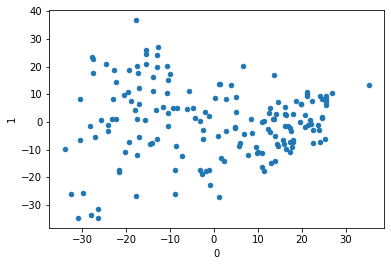

In [106]:
trans_df = pd.DataFrame(word_embeddings_transformed)
trans_df.plot.scatter(0,1)

In [75]:
# get a list of target descriptions
# get embeddings from GPT2 of the descriptions
# perform ISOMAP on the data

# TO APPLY
# get GPT2 embedding of testing text
# apply isomap
# KNN to get best target (filtered to only include targets from SDGs that it has been classfied as)

In [ ]:
# Get embedding of targets using a model and save mebeddings to disk
# apply isomap for dimensionality reduction and save output to disk to save space